In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv3D, BatchNormalization, LeakyReLU, MaxPooling3D, Flatten, Dropout
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import numpy as np
import math
import sys
import os
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
from plyfile import *
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d 
import numpy as np
import scipy.stats
import random
import pandas as pd
from sklearn.metrics import confusion_matrix

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
#点云文件导入
##############导入点云数据#################
pcd_AC13_1 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC13-1.ply")
pcd_AC13_2 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC13-2.ply")
pcd_AC16_3 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC16-3.ply")
pcd_AC16_4 = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/AC16-4.ply")
pcd_UT5_1  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-1.ply")
pcd_UT5_2  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-2.ply")
pcd_UT5_3  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-3.ply")
pcd_UT5_4  = o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/UT5-4.ply")
pcd_SMA13_1= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/SMA13-1.ply")
pcd_SMA13_2= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/SMA13-2.ply")
pcd_OGFC10_1= o3d.io.read_point_cloud("C:/Users/Administrator/Desktop/surface/OGFC10-1.ply")
#############点云标准化####################
def standard_pointcloud(point_cloud):
    Point_standard=[]
    Point=np.asarray(point_cloud.points)    
    x=np.array(Point[:,0])[...,np.newaxis]
    y=np.array(Point[:,1])[...,np.newaxis]
    z=np.array(Point[:,2])[...,np.newaxis]
    Point_standard=np.concatenate((x-np.min(x),y-np.min(y),z-np.min(z)),axis=-1)
    return Point_standard
    
AC13_1=standard_pointcloud(pcd_AC13_1)
AC13_2=standard_pointcloud(pcd_AC13_2)
AC16_3=standard_pointcloud(pcd_AC16_3)
AC16_4=standard_pointcloud(pcd_AC16_4)
UT5_1=standard_pointcloud(pcd_UT5_1)
UT5_2=standard_pointcloud(pcd_UT5_2)
UT5_3=standard_pointcloud(pcd_UT5_3)
UT5_4=standard_pointcloud(pcd_UT5_4)
SMA13_1= standard_pointcloud(pcd_SMA13_1)
SMA13_2= standard_pointcloud(pcd_SMA13_2)
OGFC10_1 =  standard_pointcloud(pcd_OGFC10_1)

point_cloud_array_group = []
point_cloud_array_group.append(AC13_1)
point_cloud_array_group.append(AC13_2)
point_cloud_array_group.append(AC16_3)
point_cloud_array_group.append(AC16_4)
point_cloud_array_group.append(UT5_1)
point_cloud_array_group.append(UT5_2)
point_cloud_array_group.append(UT5_3)
point_cloud_array_group.append(UT5_4)
point_cloud_array_group.append(SMA13_1)
point_cloud_array_group.append(SMA13_2)
point_cloud_array_group.append(OGFC10_1)
#############点云标准化####################
def standard_pointcloud(point_cloud):
    Point_standard=[]  
    x=np.array(point_cloud[:,0])[...,np.newaxis]
    y=np.array(point_cloud[:,1])[...,np.newaxis]
    z=np.array(point_cloud[:,2])[...,np.newaxis]
    Point_standard=np.concatenate((x-np.min(x),y-np.min(y),z-np.min(z)),axis=-1)
    return Point_standard
#############点云转体素####################
def voxel_transform(point_cloud, leaf_size, x_max, y_max, z_max, random=False):
    # 计算边界点
    """
    x_min, y_min, z_min = np.amin(point_cloud, axis=0) #计算x y z 三个维度的最值
    x_max, y_max, z_max = np.amax(point_cloud, axis=0)
    """
    x_min = 0
    y_min = 0
    z_min = 0
    # 计算 voxel grid维度
    Dx = (x_max - x_min)//leaf_size + 1
    Dy = (y_max - y_min)//leaf_size + 1
    Dz = (z_max - z_min)//leaf_size + 1
    #print("Dx x Dy x Dz is {} x {} x {}".format(Dx, Dy, Dz))
    
    #建立包络空间
    filtered_points = np.zeros(shape=(int(Dx),int(Dy),int(Dz),1))
 
    # 计算每个点的voxel索引
    for i in range(len(point_cloud)):
        hx = int((point_cloud[i][0] - x_min)//leaf_size)
        hy = int((point_cloud[i][1] - y_min)//leaf_size)
        hz = int((point_cloud[i][2] - z_min)//leaf_size)
        filtered_points[hx][hy][hz][0]=1
        
    return  filtered_points
######################按照计算的H_final进行窗口滑动切分#########################
H_final=51
AC13=[0,6,4,3.5,5.5,7.5,10.5,16,23.5,18.5,5,0]#级配
AC16=[0,5.4,2.4,2.4,3.7,4.1,7.8,5.5,26.3,20.1,16.6,5.7]#级配 
SMA13=[0,10.7,2.1,1.4,1.1,1.2,2.9,9.4,30.3,31.5,8.2,1.2]#级配
UT5=[0,6.7,2,2.5,5,20,13.4,48.8,1.5,0.1,0,0]#级配
OGFC10=[0,4,1.5,2,2,2.5,4,44,35,5,0,0]#级配
def split_slide(point_cloud_array_origion,H_new=H_final, intervial =[5,5]):
    L=int(np.max(point_cloud_array_origion[:,0]))
    W=int(np.max(point_cloud_array_origion[:,1]))
    Vox_small = []
    L_intervial = intervial[0]
    W_intervial = intervial[1]
    for i in range (0,L-H_new,L_intervial):
        for j in range (0,W-H_new,W_intervial):
            temp_point_cloud = point_cloud_array_origion[np.where((point_cloud_array_origion[:,1]>i)&
                                                                  (point_cloud_array_origion[:,1]<(H_new+i))&
                                                                  (point_cloud_array_origion[:,0]>j)&
                                                                  (point_cloud_array_origion[:,0]<(H_new+j)))]
            temp_point_cloud = standard_pointcloud(temp_point_cloud)
            ####点云转体素
            temp_Vox = voxel_transform(temp_point_cloud, leaf_size=0.5,x_max=51,y_max=51,z_max=10, random=False)

            Vox_small.append(temp_Vox)
    
    return Vox_small
####################原始图像拆分子点云集########################################
PointCloud_new =np.zeros((1,103,103,21,1))
#制作Ground truth
Y_Data=np.zeros((1,12))
for i in range(11):
    temp=split_slide(point_cloud_array_group[i])
    PointCloud_new=np.concatenate((PointCloud_new,temp),axis=0)
    if (i==0) or (i==1):
        temp2 = np.full((len(temp),12),AC13)
    elif (i==2) or (i==3):
        temp2 = np.full((len(temp),12),AC16)
    elif (i==4) or (i==5) or (i==6) or (i==7):
        temp2 = np.full((len(temp),12),UT5)
    elif (i==8) or (i==9):
        temp2 = np.full((len(temp),12),SMA13)
    elif (i==10):
        temp2 = np.full((len(temp),12),OGFC10) 
    #print(temp2.shape)
    Y_Data = np.concatenate((Y_Data,temp2),axis=0)
    #print(np.array(Y_Data).shape)
Y_Data = np.delete(Y_Data, 1, 0)#把第一行0删掉
PointCloud_new = np.delete(PointCloud_new, 1, 0)#把第一行0删掉
PointCloud_new =np.array(PointCloud_new)
print(Y_Data.shape)
print(PointCloud_new.shape)

(1579, 12)
(1579, 103, 103, 21, 1)


In [9]:
#### 数据集1579分，切分为1379训练 200测试#######################
arr = np.array(range(0, 1579, 1))
r = np.random.permutation(arr)
Train_X_Data = []
Train_Y_Data = []
for i in range(1379):
    Train_X_Data.append(PointCloud_new[r[i]])
    Train_Y_Data.append(Y_Data[r[i]])

Test_X_Data = []
Test_Y_Data = []
for i in range(1379,1579):
    Test_X_Data.append(PointCloud_new[r[i]])
    Test_Y_Data.append(Y_Data[r[i]])
    
Train_X_Data = np.array(Train_X_Data)
Train_Y_Data = np.array(Train_Y_Data)
Test_X_Data = np.array(Test_X_Data)
Test_Y_Data = np.array(Test_Y_Data)

print(Train_X_Data.shape)
print(Train_Y_Data.shape)
print(Test_X_Data.shape)
print(Test_Y_Data.shape)

(1379, 103, 103, 21, 1)
(1379, 12)
(200, 103, 103, 21, 1)
(200, 12)


In [5]:
def get_model(input_size, num_classes):
    model = Sequential()

    model.add(Conv3D(32, (5, 5, 5), strides=(2, 2, 2), padding="valid", input_shape=input_size))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Conv3D(32, (3, 3, 3), strides=(1, 1, 1), padding="valid"))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(128))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(num_classes, activation="relu"))

    return model

In [6]:
VoxNet =get_model((103, 103, 21, 1),12)
VoxNet.summary()
Batch_size=8
lr=1e-3
VoxNet.compile(optimizer=keras.optimizers.Adam(lr), loss=tf.keras.losses.MAE)
Callback = keras.callbacks.ModelCheckpoint("VoxNet.h5", 
                                           monitor='val_loss', 
                                           save_best_only=True, 
                                           save_weights_only=True)
Model_history=VoxNet.fit(x=Train_X_Data,y=Train_Y_Data,batch_size=Batch_size,epochs =200,validation_split=0.2,callbacks=Callback)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 50, 50, 9, 32)     4032      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 50, 50, 9, 32)     0         
_________________________________________________________________
batch_normalization (BatchNo (None, 50, 50, 9, 32)     128       
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 9, 32)     0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 48, 48, 7, 32)     27680     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 7, 32)     0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 7, 32)     1

138/138 [==============================] - 2s 18ms/step - loss: 1.8981 - val_loss: 2.6019: 1.89 - ETA: 0s - loss: 1.8 - ETA: 0s - loss: 1.899 - ETA: 0s - loss: 1
Epoch 36/200
138/138 [==============================] - 2s 18ms/step - loss: 1.7467 - val_loss: 0.9961 ETA: 1s - loss: 1.70 - ETA: 0s - loss: 1.7 - ETA: 0s - loss: - ETA: 0s - loss: 1. - ETA: 0s - loss: 1.74
Epoch 37/200
138/138 [==============================] - 2s 18ms/step - loss: 1.8882 - val_loss: 1.0920: 0s - loss: - ETA: 0s - loss: 1. - ETA: 0s - loss: 1.8
Epoch 38/200
138/138 [==============================] - 2s 18ms/step - loss: 1.7770 - val_loss: 1.0370- ETA: 1s - - ETA: 0s - l - ETA: 0s - loss: 1
Epoch 39/200
138/138 [==============================] - 2s 18ms/step - loss: 1.8677 - val_loss: 1.4392A: 0s - loss: 1.896 - ETA: 0s - loss: 1.8 - ETA: 0s - loss: 1.886 - ETA: 0s - loss: 1.8 - ETA: 0s - loss: 1.878 - ETA: 0s - loss: 1.876 - ETA: 0s - loss: 1.8
Epoch 40/200
138/138 [==============================] - 2s 18ms/

138/138 [==============================] - 2s 18ms/step - loss: 1.6546 - val_loss: 1.0125- ETA: 0s - loss: 1.60 - ETA: 0s - loss: 1.61 - ETA: 0s - loss: 1 - ETA: 0s - loss: 1
Epoch 86/200
138/138 [==============================] - 2s 18ms/step - loss: 1.6322 - val_loss: 1.00971s - loss: 1.6 - ETA: 1s - - ETA: 0s - loss: 1
Epoch 87/200
138/138 [==============================] - 2s 18ms/step - loss: 1.5321 - val_loss: 1.3033 - loss: 1.4 - ETA: 0s - loss: 1. - ETA: 0s - 
Epoch 88/200
138/138 [==============================] - 2s 18ms/step - loss: 1.7367 - val_loss: 1.4338A: 1s - loss: 1.72 - ETA: 1s - loss: 1.728 - ETA: 1s - l - ETA: 0s - loss:
Epoch 89/200
138/138 [==============================] - 2s 18ms/step - loss: 1.8235 - val_loss: 1.0182s:  - ETA: 0s - loss: 1.8 - ETA: 0s - loss: 1.826
Epoch 90/200
138/138 [==============================] - 2s 18ms/step - loss: 1.7411 - val_loss: 1.0270A: 
Epoch 91/200
138/138 [==============================] - 2s 18ms/step - loss: 1.6152 - val_lo

138/138 [==============================] - 2s 18ms/step - loss: 1.5050 - val_loss: 0.9894 0s - loss: 1.487 - ETA: 0s - loss: 1.490 - ETA: 0s - loss: 1.
Epoch 137/200
138/138 [==============================] - 2s 18ms/step - loss: 1.6309 - val_loss: 1.0374
Epoch 138/200
138/138 [==============================] - 2s 18ms/step - loss: 1.7767 - val_loss: 1.3913
Epoch 139/200
138/138 [==============================] - 2s 18ms/step - loss: 1.6883 - val_loss: 1.0443
Epoch 140/200
138/138 [==============================] - 2s 18ms/step - loss: 1.6087 - val_loss: 1.0481 1s - loss: 1.6 - ETA: 0s - loss: 1.616 - ETA: 0s - loss: 1.614 - ETA: 0s - loss: 1.61 - ETA: 0s - loss: 1 - ETA: 0s - loss: 1.6 - ETA: 0s - loss: 1.
Epoch 141/200
138/138 [==============================] - 2s 18ms/step - loss: 1.5793 - val_loss: 1.1193- ETA: 1s - loss: 1.577 - ETA:  - ETA: 0s - loss: 
Epoch 142/200
138/138 [==============================] - 2s 18ms/step - loss: 1.7171 - val_loss: 1.14741s - l - ETA: 0s - loss: 1

138/138 [==============================] - 2s 18ms/step - loss: 1.6269 - val_loss: 1.1510s - loss: - ETA: 0s - los - ETA: 0s - loss: 1.621 - ETA: 0s - loss: 1.
Epoch 188/200
138/138 [==============================] - 2s 18ms/step - loss: 1.6006 - val_loss: 1.0366- loss: 1.631 - ETA: 1s - lo - ETA: 0s - loss: 1 - ETA: 0s - loss: 1.60 - ETA: 0s - loss: 1.60 - ETA: 0s - loss: 1.60 - ETA: 0s - loss: 1.601
Epoch 189/200
138/138 [==============================] - 2s 18ms/step - loss: 1.5740 - val_loss: 1.3652 ETA: 1s - loss:  - ETA: 1s - loss: 1.58 - ETA: 1s - loss: 1 - ETA: 0s - loss: - ETA: 0s - loss: 1.582 - ETA: 0s - loss
Epoch 190/200
138/138 [==============================] - 2s 18ms/step - loss: 1.6145 - val_loss: 1.0103 ETA: 1s - los - ETA: 0s - loss: - ETA: 0s - loss: 1. - ETA: 0s - loss: 1.61
Epoch 191/200
138/138 [==============================] - 2s 18ms/step - loss: 1.7533 - val_loss: 1.2976 ETA: 1s - loss: 1.7 - ETA: 1s - loss: 1 - ETA: 0
Epoch 192/200
138/138 [================

In [7]:
Save_history = Model_history.history
Save_history = pd.DataFrame(Save_history)
writer = pd.ExcelWriter('C:/Users/Administrator/Desktop/surface/实验结果存放/VoxxNet_loss.xlsx')  #关键2，创建名称为hhh的excel表格
Save_history.to_excel(writer,'page_1',float_format='%.5f')  #关键3，float_format 控制精度，将data_df写到hhh表格的第一页中。若多个文件，可以在page_2中写入
writer.save()  

7/7 [==============================] - 0s 15ms/step - loss: 0.6300


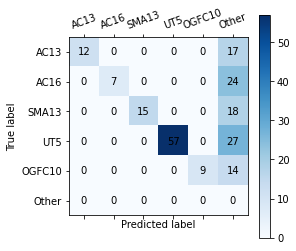

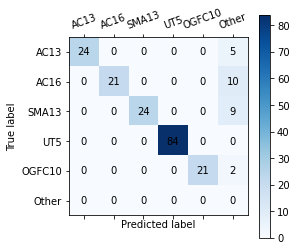

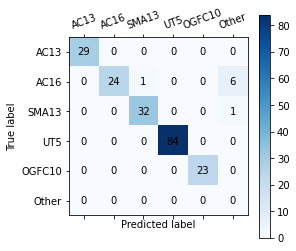

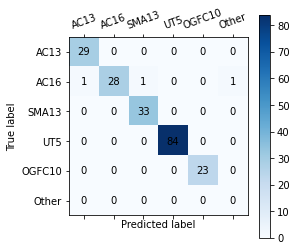

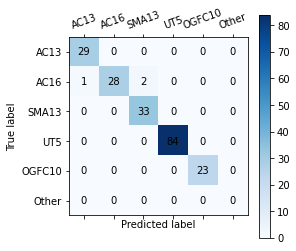

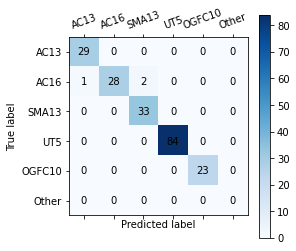

In [11]:
############Test性能测试###################
def identification(predicted_gradient,real_gradient,threshold):
    AC13=[0,6,4,3.5,5.5,7.5,10.5,16,23.5,18.5,5,0]#级配
    AC16=[0,5.4,2.4,2.4,3.7,4.1,7.8,5.5,26.3,20.1,16.6,5.7]#级配 
    SMA13=[0,10.7,2.1,1.4,1.1,1.2,2.9,9.4,30.3,31.5,8.2,1.2]#级配
    UT5=[0,6.7,2,2.5,5,20,13.4,48.8,1.5,0.1,0,0]#级配
    OGFC10=[0,4,1.5,2,2,2.5,4,44,35,5,0,0]#级配
    if np.average(np.abs(real_gradient-AC13))==0:
        Real_result=0
    elif np.average(np.abs(real_gradient-AC16))==0:
        Real_result=1
    elif np.average(np.abs(real_gradient-SMA13))==0:
        Real_result=2
    elif np.average(np.abs(real_gradient-UT5))==0:
        Real_result=3
    elif np.average(np.abs(real_gradient-OGFC10))==0:
        Real_result=4
        
    R_AC13=np.average(np.abs(predicted_gradient-AC13))
    R_AC16=np.average(np.abs(predicted_gradient-AC16))
    R_SMA13=np.average(np.abs(predicted_gradient-SMA13))
    R_UT5=np.average(np.abs(predicted_gradient-UT5))
    R_OGFC10=np.average(np.abs(predicted_gradient-OGFC10))
    
    Predicted_result =np.argmin(np.array([R_AC13,R_AC16,R_SMA13,R_UT5,R_OGFC10]))
    
    if np.min(np.array([R_AC13,R_AC16,R_SMA13,R_UT5,R_OGFC10]))>threshold:
        Predicted_result = 5
    
    return Real_result, Predicted_result

n_classes = 12
Batch_size=4
VoxNet =get_model((103, 103, 21, 1),12)
VoxNet.load_weights("VoxNet.h5")
VoxNet.compile(optimizer=keras.optimizers.Adam(lr), loss=tf.keras.losses.MAE)
VoxNet.evaluate(Test_X_Data,Test_Y_Data)
Thr_list = [0.5,1,1.5,2,2.5,3]
for Thr in Thr_list:
    Real_result = []
    Predicted_result = []
    for i in range(len(Test_X_Data)):
        R,P=identification(VoxNet(np.array(Test_X_Data[i])[np.newaxis,...])[0],Test_Y_Data[i],Thr)
        Real_result.append(R)
        Predicted_result.append(P)
    #######绘制混淆矩阵################
    C = confusion_matrix(Real_result, Predicted_result, labels=[0,1,2,3,4,5]) 
    plt.matshow(C, cmap=plt.cm.Blues) # 根据最下面的图按自己需求更改颜色
    plt.colorbar()
    for i in range(len(C)):
        for j in range(len(C)):
            plt.annotate(C[j, i], xy=(i, j), horizontalalignment='center', verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(range(0,6), labels=['AC13','AC16','SMA13','UT5','OGFC10','Other'], rotation=20) # 将x轴或y轴坐标，刻度 替换为文字/字符
    plt.yticks(range(0,6), labels=['AC13','AC16','SMA13','UT5','OGFC10','Other'])
    plt.savefig('C:/Users/Administrator/Desktop/surface/实验结果存放/VoxNet'+str(Thr)+'.png',dpi=600)#保存图片
    plt.show()